<div dir=rtl>
آلزایمر یک بیماری پیشرونده نورولوژیکی می باشد که باعث انحطاط بعضی عملکرد های شناختی می شود (mandal and Shukla , 2018).  تاکنون هیچ درمان قطعی برای درمان بیماری آلزایمر کشف نشده است ، لذا تشخیص زودهنگام این بیماری می تواند به جلوگیری از پیشرفت این دمانس کمک کند (zamanzadeh and gharibzadeh ,2021) .
مطالعات بسیاری نشان داده اند که می توان با استفاده از داده های تغییرات نقاط مختلف مغزی (Kishore ,kumar and pavani ,2020) و تغییرات نورولوژیکی مغز ، وجود بیماری الزایمر را از طریق یادگیری ماشین تشخیص داد . 
در اینجا تلاش شده تا با استفاده از داده های موجود در سایت kaggle در آدرس زیر :
https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images
 با به کارگیری یادگیری عمیق ، مدلی طراحی شود تا بتوان آلزایمر را به صورت خودکار و بدون نیاز به متخصصین این حوزه ، تشخیص داد. 
</div>

<div dir=rtl>
در صورتی که داده هایتان را در گوگل کولب اجرا می کنید ، می توانید آن را به صورت زیر باز کنید  
<div>

In [1]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/Alzheimer Dataset.zip" , "r") as data : 
  data.extractall()
print("done")

done


In [2]:
import keras
import itertools
import tensorflow
import numpy as np
from keras import regularizers
from keras.models import Model , Sequential
from sklearn.metrics import confusion_matrix
from keras.applications.resnet import ResNet101 
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten , Input , Dropout , BatchNormalization , Dense , Activation , MaxPooling2D

In [3]:
import os 

base_dir = "/content/Alzheimer_s Dataset"
train_path = os.path.join(base_dir , "train")
test_path = os.path.join(base_dir , "test")

train_MildDemented = os.path.join(train_path , "MildDemented")
train_ModerateDemented = os.path.join(train_path , "ModerateDemented")
train_NonDemented = os.path.join(train_path , "NonDemented")
train_VeryMildDemented = os.path.join(train_path , "VeryMildDemented")

test_MildDemented = os.path.join(test_path , "MildDemented")
test_ModerateDemented = os.path.join(test_path , "ModerateDemented")
test_NonDemented = os.path.join(test_path , "NonDemented")
test_VeryMildDemented = os.path.join(test_path , "VeryMildDemented")

<div dir=rtl>
در زیر ، تنها یک پیش پردازش rescale بر روی داده ها اعمال می شود  و تمام کانال ها تقسیم بر 255 می شوند تا مقدار هر کانال بین صفر و یک قرار گیرد.
سپس با استفاده از data image generator داده ها را به صورت batch آماده ی انتقال به مدل برای پردازش می کنیم.
<div>

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #width_shift_range  =0.05,
    #zoom_range = 0.10,
    rotation_range= 5,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(208,176),
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    batch_size=50
)

validation_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(208,176),
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(208,176),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128

)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


<div dir=rtl>
با توجه به این که یکی از کلاس های موجود در دیتاست moderate demented  به نسبت مابقی کلاس ها ، تعداد بسیار کم تری نمونه دارد ، از روش class weight برای برطرف کردن این عدم توازن در داده ها استفاده می توان استفاده کرد.
در زیر فراوانی کلاسی که بیشترین تعداد نمونه داشته است بر فراوانی هر کلاس تقسیم و مقدار حاصل شده را به عنوان وزن آن کلاس به مدل پاس می دهیم.
<div>

In [5]:
mildDemented_NUM = 717
moderateDemented_NUM = 52
nonDemented_NUM = 2560
verymilddemented_NUM = 1792

mildDemented_weight = 2560.0/mildDemented_NUM
moderateDemented_weight = 2560.0/moderateDemented_NUM
nonDemented_weight = 2560.0/nonDemented_NUM
verymilddemented_weight = 2560.0/verymilddemented_NUM

<div dir=rtl>
در این قسمت ، دو شبکه کانولوشنی از قبل آموزش دیده برای مقایسه بین آن دو تعریف می شوند ؛ resnet101 vs inception_v3 . به دلیل آن که classifier مورد نیاز برای تشخیص آلزایمر با classifier داده های imagenet متفاوت هست ، از لایه های FC این دو مدل از قبل آموزش داده  استفاده نمیکنیم . سایز ورودی داده ها را همان سایز عکس های mri مغزی موجود در داده ها قرار می دهیم . آزمایش خطا نشان داد که سایز اصلی عکس های mri از سایز داده های  image net دقت بیشتری را به همراه دارد.
<div>

In [6]:
conve_base = ResNet101(
    include_top = False,
    input_shape=(208,176,3),
    weights="imagenet"    
)


<div dir=rtl>
همانطور که مشاهده می کنید ، قابلیت آموزش تمام لایه های موجود در "مدل از قبل آموزش دیده" را False قرار می دهیم.
<div>

In [7]:
for layer in conve_base.layers : 
  layer.trainable = False
#conve_base.summary()




<div dir=rtl>
در زیر از روش functional api برای ساخت مدل استفاده می شود. این مدل دو شاخه دارد که در انتها با یکدیگر ادغام می شوند. در یکی از شاخه با استفاده از شبکه های کانولوشنی و kernel 3*3 و در شاخه ی دوم مدل قبلا آموزش دیده conve_base و conve_base_2 ورودی را گرفته و با استفاده از چند لایه fc پردازش می شود.
<div>

In [8]:
inp1 = Input(shape=(208 , 176 , 3))

cnn = keras.layers.SeparableConv2D(264 , 3 , kernel_regularizer=regularizers.l2(0.001) , activation="relu" )(inp1)
cnn = MaxPooling2D()(cnn)
cnn = keras.layers.SeparableConv2D(128 , 3 , kernel_regularizer=regularizers.l2(0.001) ,  activation="relu")(cnn)
cnn = MaxPooling2D()(cnn)
cnn = keras.layers.SeparableConv2D(64 , 3 , kernel_regularizer=regularizers.l2(0.001) ,  activation="relu")(cnn)
cnn = Dropout(0.5)(cnn)
#cnn = BatchNormalization()(cnn)
cnn = Flatten()(cnn)
#cnn = BatchNormalization()(cnn)

X = conve_base(inp1)
X = Dropout(0.5)(X)
X = Flatten()(X)
X = BatchNormalization()(X)
X = Dense(320,kernel_initializer='RandomNormal')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(264,kernel_initializer='RandomNormal')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(128,kernel_initializer='RandomNormal')(X)
X = (BatchNormalization())(X)
X = (Activation('relu'))(X)

merged = keras.layers.concatenate([cnn , X])
predictor = Dense(4 , activation="softmax")(merged)

model = Model(inputs=[inp1] , outputs=predictor)




<div dir=rtl>
در قسمت زیر با توجه به این که چهار کلاس متفاوت داریم ، از categorical crossentropy  به عنوان loss function استفاده می کنیم. Metric انتخاب شده ، AUC می باشد که به معنای ناحیه زیر منحنی ROC می باشد. زمانی که true positive rate در مقابل False positive rate روی نمودار رسم شود ، خط رسم شده را ROC و ناحیه پایینی این خط را AUC گویند . 
<div>

In [9]:
model.compile(loss="categorical_crossentropy",
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.01),
              metrics=tensorflow.keras.metrics.AUC(name = 'auc'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


<div dir=rtl>
در زیر چهار نوع callback تعریف شده است. مورد اول tensorboard می باشد که می توان از آن برای مشاهده نتایج و یا مقایسه نتایج هایپر پارامتر های مختلف از آن بهره برد.
مورد دوم early stoping ، زمانی کاربرد دارد که مدل ما بعد از یک تعداد patience خاص ، دیگر عملکرد بهتری در دیتای validation نداشته باشد و ما بخواهیم در کناار ذخیره کردن بهترین مدل ، جلوی train را بگیرد.
کالبک سوم learning rate scheduler نام دارد که وظیفه آن ، تغییر دادن مقدار پارامتر "نرخ یادگیری" در epoch های متفاوت می باشد. در زیر می توانید آرایش نرخ یادگیری را در epoch های متفاوت مشاهده کنید.
به جای دو مورد قبلی می توان از یک کالبک سومی استفاده کرد که بعد از یک تعداد خاص patience اگر عملکرد شبکه بهتر نشد ، ضریب نرخ یادگیری شبکه را در یک عدد کوچکتر از یک ضرب کند تا تا نرخ یادگیری کوچکتر شود (شبکه در حال رسیدن به global minimum می باشد ، پس بهتر است نرخ یادگیری کوچکتر باشد). در صورتی که نرخ یادگیری از یک میزان از قبل تعیین شده توسط min_lr کوکتر شود ، شبکه متوقف می شود.
<div>

In [10]:
#mkdir my_log_dir

logDir = "my_log_dir/resnet/"
tensor_board = [
                keras.callbacks.TensorBoard(
                  log_dir=logDir,
                  histogram_freq=1,
                  update_freq="epoch"
             )
]

early_stoping = [
                 keras.callbacks.EarlyStopping(
                     monitor="val_auc",
                     patience=10,
                     verbose=1,
                     mode="auto",
                     restore_best_weights=True
                 )
]

def scheduler (epoch):
  if epoch < 9:
    return 0.01
  elif epoch < 30:
    return 0.001
  else:
    return 0.0001

learning_rate_scheduler = keras.callbacks.LearningRateScheduler(scheduler , verbose=1 , )

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    mode="auto" )

<div dir=rtl>
در بالا ، وزن مناسب هر کلاس تعریف شده است ، حال به صورت یک دیکشنری ، وزن هر کلاس تعریف می شود تا به مدل پاس داده شود.
بعد از آن با استفاده از train_generator  که توسط ImageDataGenerator تعریف شده ، داده ها را به model.fit پاس می دهیم تا مدل ساخته شود. همچنین انواع کالبک هایی که تعریف کرده ایم نیز ، به صورت لیست ، به عنوان کالبک به مدل اضافه می کنیم.
<di>

In [11]:
class_weight = {0:mildDemented_weight , 1:moderateDemented_weight , 2:nonDemented_weight , 3:verymilddemented_weight}

history=model.fit(
      train_generator,
      steps_per_epoch=80,
      epochs=40, 
      validation_data = validation_generator,
      validation_steps=31,
      callbacks=[learning_rate_scheduler, early_stoping ,tensor_board ],
      verbose=1,
      #class_weight=class_weight
  )

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
80/80 [==============================] - 188s 2s/step - loss: 1.0137 - auc: 0.7624 - val_loss: 2.0304 - val_auc: 0.8230
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
80/80 [==============================] - 137s 2s/step - loss: 0.7994 - auc: 0.8222 - val_loss: 1.2463 - val_auc: 0.8428
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
80/80 [==============================] - 134s 2s/step - loss: 0.7211 - auc: 0.8461 - val_loss: 1.2416 - val_auc: 0.8582
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
80/80 [==============================] - 134s 2s/step - loss: 0.6824 - auc: 0.8598 - val_loss: 1.1618 - val_auc: 0.8698
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
80/80 [==============================] - 134s 2s/step - loss: 0.5940 - auc: 0.8720 - val_loss: 0.9868 - val_auc: 0.8814
Epoch

<div dir=rtl>
برای نمایش نتایج validation و train ، از کتابخانه matplotlib استفاده میکنیم.
<div>

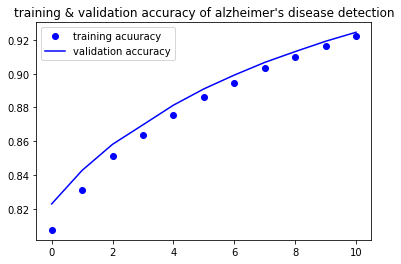

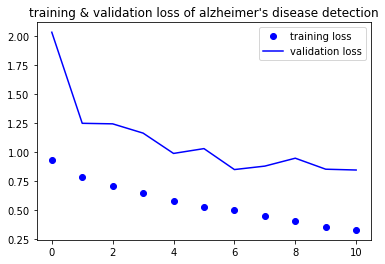

In [12]:
import matplotlib.pyplot as plt

accuracy = history.history["auc"]
val_accuracy = history.history["val_auc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_num = range(len(accuracy))

plt.plot(epochs_num , accuracy , "bo" , label="training acuuracy")
plt.plot(epochs_num , val_accuracy , "b"  , label="validation accuracy")
plt.title("training & validation accuracy of alzheimer's disease detection")
plt.legend()
plt.figure()

plt.plot(epochs_num , loss , "bo" , label="training loss")
plt.plot(epochs_num , val_loss , "b"  , label="validation loss")
plt.title("training & validation loss of alzheimer's disease detection")
plt.legend()
plt.show()